In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import ConvClassifierUs
from pclib.nn.layers import Conv2d
from pclib.optim.train import train
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import format_y
from pclib.utils.customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class PadTransform(object):
    def __call__(self, tensor):
        return F.pad(tensor, (2, 2, 2, 2), value=0)

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    # transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 10
# dataset = torch.utils.data.Subset(dataset, range(length))
# train_dataset = PreloadedDataset.from_dataset(dataset, train_transform, device)

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

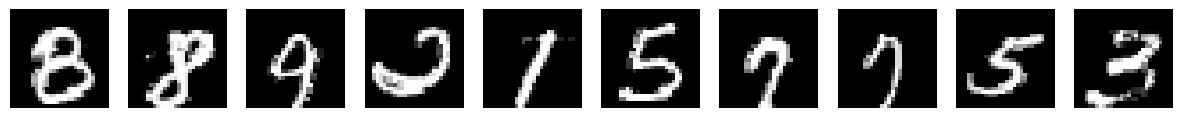

Max value:  tensor(1., device='cuda:0')
Min value:  tensor(0., device='cuda:0')


In [4]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [5]:
seed = 42
torch.manual_seed(seed)

model_name = 'ConvClassifierSS'
model = ConvClassifierUs(
    bias=True, 
    symmetric=True, 
    precision_weighted=False,
    actv_fn=F.relu,
    steps=100,
    gamma=0.1,
    ).to(device)
step = 0
stats = None

In [6]:
# Train Loop
NUM_EPOCHS = 30
BATCH_SIZE = 1000
REG_COEFF = 0.05
# val_dataset = None

step, stats = train(
    model, 
    model_name,
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr = 0.0001,
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    flatten=False,
    stats=stats,
    optim='AdamW',
    minimal_stats=True,
    val_grads=False,
    save_best=False,
)

NUM_EPOCHS = 10
step, stats = train(
    model, 
    model_name,
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    lr = 0.00001,
    c_lr = 1e-3,
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    flatten=False,
    stats=stats,
    optim='AdamW',
    minimal_stats=True,
    val_grads=True,
)

# plot_stats(stats, model)

KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(), 'weights/mnist_conv_classifier_ss_v2.pt')

In [8]:
model.load_state_dict(torch.load('weights/mnist_conv_classifier_ss_v2.pt'))

FileNotFoundError: [Errno 2] No such file or directory: 'weights/mnist_conv_classifier_ss_v2.pt'

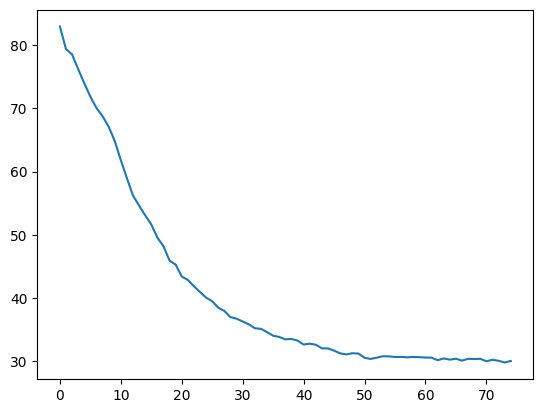

In [7]:
plt.plot(stats['train_vfe'])

tensor(1., device='cuda:0') tensor(-1., device='cuda:0')
tensor(0.7994) tensor(-0.4500)


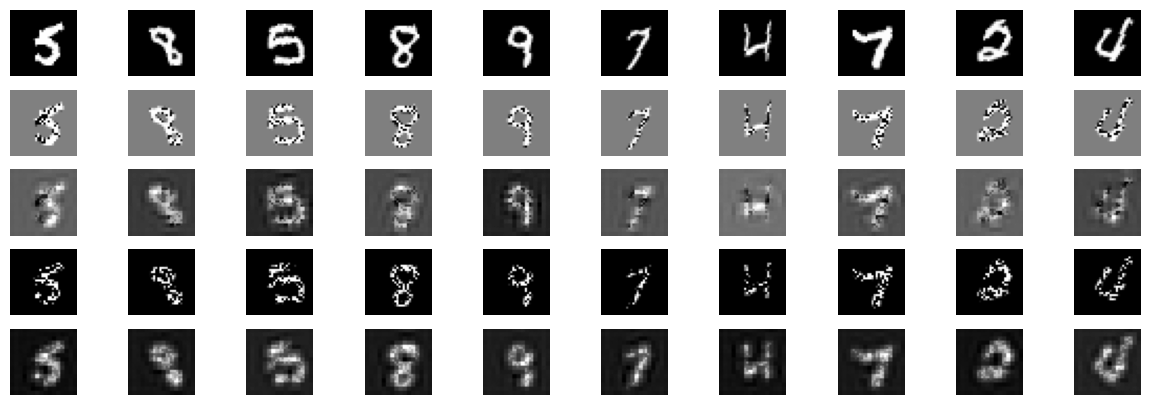

In [11]:
X = train_dataset.transformed_images[:10]
X_noisy = X + torch.randn_like(X) * 2.0
X_noisy = F.normalize(X_noisy, dim=1) * X.norm(dim=1, keepdim=True)
X_noisy_recon = model.reconstruct(X_noisy.to(device).detach())[0].detach().cpu()
X_partial = X * (torch.rand_like(X) < 0.5).float()
X_partial_recon = model.reconstruct(X_partial.to(device))[0].detach().cpu()

print(X_noisy.max(), X_noisy.min())
print(X_noisy_recon.max(), X_noisy_recon.min())

# Show all 10 images, raw, noised and reconstructed
fig, axes = plt.subplots(5, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(X[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(X_noisy[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(X_noisy_recon[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[3]):
    ax.imshow(X_partial[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[4]):
    ax.imshow(X_partial_recon[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')

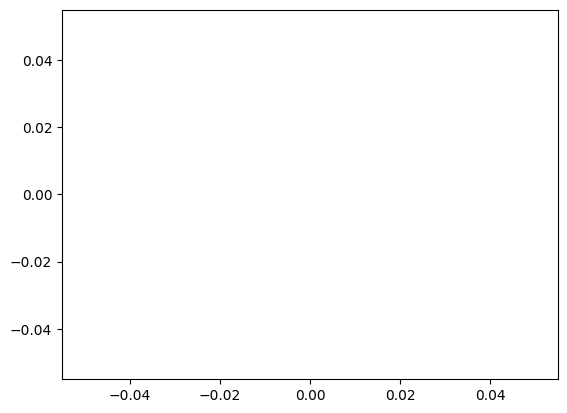

In [10]:
plt.plot(stats['val_acc'])

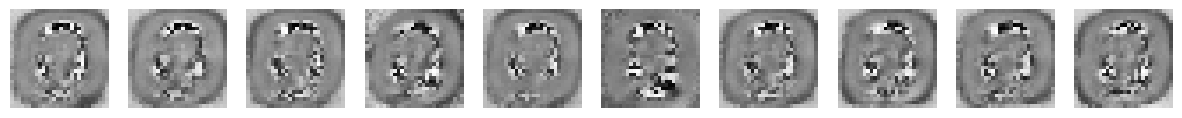

In [23]:
targets = torch.arange(NUM_CLASSES).to(device)
y = format_y(targets, NUM_CLASSES)
_, state = model(y=y, lmda=0.00)
images = state[-1]['x']

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

In [15]:
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [12]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0, flatten=False)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.11341666666666667 | error_rate: 88.66 %


In [7]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

NameError: name 'num_models' is not defined

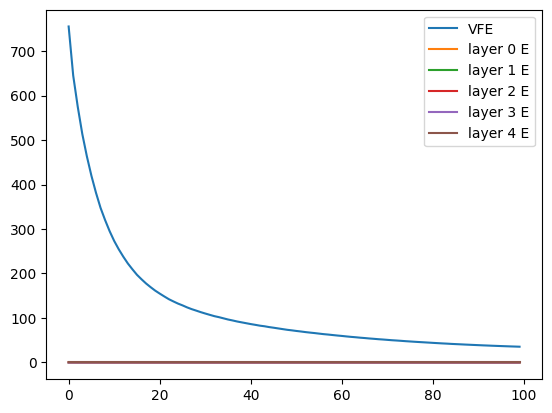

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


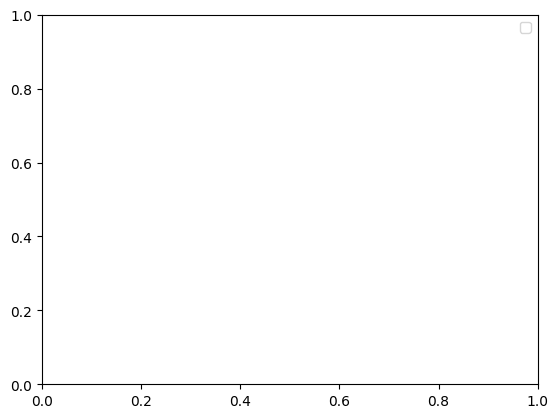

([755.24169921875,
  645.0504150390625,
  574.6920776367188,
  513.47314453125,
  463.4270935058594,
  419.7116394042969,
  381.571044921875,
  347.69769287109375,
  320.2035217285156,
  295.1393127441406,
  273.1604309082031,
  254.4719696044922,
  237.8047637939453,
  222.5375518798828,
  209.47634887695312,
  197.0858612060547,
  187.0189208984375,
  177.5296630859375,
  169.27322387695312,
  161.5115509033203,
  154.8228759765625,
  148.4408416748047,
  142.2572479248047,
  137.2168731689453,
  132.4197998046875,
  128.36253356933594,
  123.84647369384766,
  119.94194793701172,
  116.5964584350586,
  113.15587615966797,
  110.02147674560547,
  107.03643798828125,
  104.1112060546875,
  101.85221099853516,
  99.21723175048828,
  96.58599090576172,
  94.4468765258789,
  92.104248046875,
  90.1564712524414,
  88.22655487060547,
  86.2789306640625,
  84.56964874267578,
  82.72807312011719,
  81.40174865722656,
  79.57563781738281,
  78.12401580810547,
  76.55055236816406,
  74.97623443

In [6]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images
y = format_y(y, 10)

track_vfe(model, x, steps=100, plot_Es=True)

In [12]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


AssertionError: This cell only works for PrecisionWeighted layers